In [1]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [30]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    return -torch.sum(likelihood)

### Test 1
``` a = gm([1.], [_mean], [1.]); ```


Genero sample da $\mathcal{N}(10,1)$

In [3]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim1.soga')
cfg = produce_cfg(compiledFile)

In [4]:
pars = {'mean':5.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [5]:
output_dist = start_SOGA(cfg, params_dict)

In [6]:
output_dist

Dist<['a'],pi: [tensor(1.)]  mu: [tensor([5.], grad_fn=<CopySlices>)] sigma: [tensor([[1.]])]>

In [7]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((100,1))

In [8]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.SGD([params_dict[key] for key in params_dict.keys()], lr=0.1)

for i in range(100):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 10 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 5.018310546875 loss: -0.0749930739402771
mean: 5.255098819732666 loss: -0.12809213995933533
mean: 5.7121262550354 loss: -0.3217780292034149
mean: 8.693161010742188 loss: -8.967405319213867
mean: 9.74962043762207 loss: -27.854455947875977
mean: 9.749625205993652 loss: -27.854461669921875
mean: 9.749625205993652 loss: -27.854461669921875
mean: 9.749625205993652 loss: -27.854461669921875
mean: 9.749625205993652 loss: -27.854461669921875
mean: 9.749625205993652 loss: -27.854461669921875


In [9]:
sampling_dist = Dist(['x'], GaussianMix([torch.tensor(1.)], [torch.tensor([sampling_mean.item()])], [torch.tensor([[sampling_std.item()]])]))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor([-27.4472])
Likelihood in the optimized distribution:  tensor([-27.8545], grad_fn=<NegBackward0>)


### Test 2

``` a = gm([1.], [10.], [_std]);  ```

In [10]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim2.soga')
cfg = produce_cfg(compiledFile)

In [11]:
pars = {'std':1.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [12]:
output_dist = start_SOGA(cfg, params_dict)

In [13]:
output_dist

Dist<['a'],pi: [tensor(1.)]  mu: [tensor([10.])] sigma: [tensor([[2.2500]], grad_fn=<CopySlices>)]>

In [14]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))
print('samples std', torch.std(samples))

samples std tensor(1.0160)


In [15]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(100):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 10 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


std: 1.4900000095367432 loss: -219.69937133789062
std: 1.3897260427474976 loss: -229.99365234375
std: 1.288261890411377 loss: -241.1048583984375
std: 1.1848667860031128 loss: -253.1498565673828
std: 1.0791888236999512 loss: -266.1878356933594
std: 0.9712917804718018 loss: -280.1757507324219
std: 0.8616734743118286 loss: -294.9239807128906
std: 0.7513236403465271 loss: -310.0419006347656
std: 0.6418326497077942 loss: -324.89801025390625
std: 0.5355991125106812 loss: -338.59185791015625


In [16]:
sampling_dist = Dist(['x'], GaussianMix([torch.tensor(1.)], [torch.tensor([sampling_mean.item()])], [torch.tensor([[sampling_std.item()**2]])]))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor([-277.8189])
Likelihood in the optimized distribution:  tensor([-349.9358], grad_fn=<NegBackward0>)


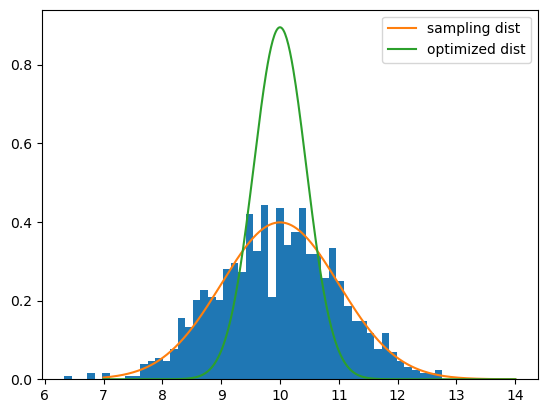

In [17]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(7,14,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), params_dict['std'].item()).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 3

```
a = gm([1.], [1.], [1.]);
a = _par1 * a + 1.;
```

sample from the program with _par1 = 2

In [18]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [19]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim3.soga')
cfg = produce_cfg(compiledFile)

In [20]:
pars = {'par1':2.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [21]:
output_dist = start_SOGA(cfg, params_dict)

In [22]:
output_dist

Dist<['a'],pi: [tensor(1.)]  mu: [tensor([2.], grad_fn=<CopySlices>)] sigma: [tensor([[4.]], grad_fn=<CopySlices>)]>

In [23]:
sampling_mean = torch.tensor(2.)
sampling_std = torch.tensor(2.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))

In [24]:
torch.var(samples)

tensor(3.9304)

In [26]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(100):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 10 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


par1: 1.9900000095367432 loss: -141.71913146972656
par1: 1.8901474475860596 loss: -145.15219116210938
par1: 1.7911361455917358 loss: -148.41177368164062
par1: 1.6940525770187378 loss: -151.41456604003906
par1: 1.6002659797668457 loss: -154.0787353515625
par1: 1.5113338232040405 loss: -156.33773803710938
par1: 1.4288873672485352 loss: -158.15426635742188
par1: 1.354480266571045 loss: -159.52789306640625
par1: 1.2894001007080078 loss: -160.497802734375
par1: 1.2344759702682495 loss: -161.13194274902344


In [27]:
sampling_dist = Dist(['x'], GaussianMix([torch.tensor(1.)], [torch.tensor([sampling_mean.item()])], [torch.tensor([[sampling_std.item()**2]])]))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor([-141.7191])
Likelihood in the optimized distribution:  tensor([-161.5132], grad_fn=<NegBackward0>)


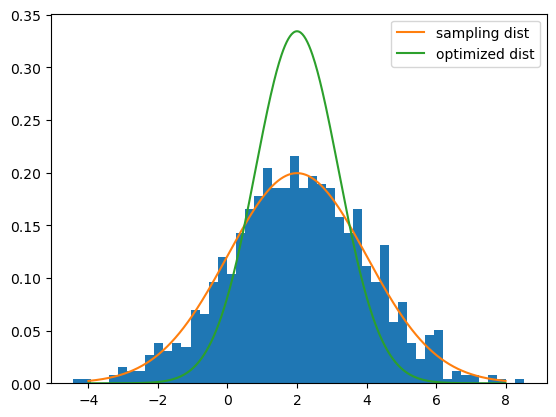

In [28]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(-4,8,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), np.sqrt(output_dist.gm.sigma[0][0,0].item())).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 4

```
a = gm([1.], [1.], [1.]);
a = 2 * a + _par2;
```

sample from the program with _par2 = 1

In [34]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [35]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim4.soga')
cfg = produce_cfg(compiledFile)

In [36]:
pars = {'par2':2.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [37]:
output_dist = start_SOGA(cfg, params_dict)

In [38]:
output_dist

Dist<['a'],pi: [tensor(1.)]  mu: [tensor([4.], grad_fn=<CopySlices>)] sigma: [tensor([[4.]])]>

In [39]:
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))

In [40]:
torch.var(samples)

tensor(3.7318)

In [42]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.001)

for i in range(100):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 10 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


par2: 1.9989999532699585 loss: -131.80584716796875
par2: 1.9890028238296509 loss: -132.0059051513672
par2: 1.9790186882019043 loss: -132.20437622070312
par2: 1.969056487083435 loss: -132.40106201171875
par2: 1.9591219425201416 loss: -132.59584045410156
par2: 1.9492188692092896 loss: -132.78863525390625
par2: 1.9393494129180908 loss: -132.9794464111328
par2: 1.9295144081115723 loss: -133.16819763183594
par2: 1.9197148084640503 loss: -133.35494995117188
par2: 1.9099509716033936 loss: -133.53964233398438


In [43]:
sampling_dist = Dist(['x'], GaussianMix([torch.tensor(1.)], [torch.tensor([sampling_mean.item()])], [torch.tensor([[sampling_std.item()**2]])]))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(-143.9855)
Likelihood in the optimized distribution:  tensor(-133.7223, grad_fn=<NegBackward0>)


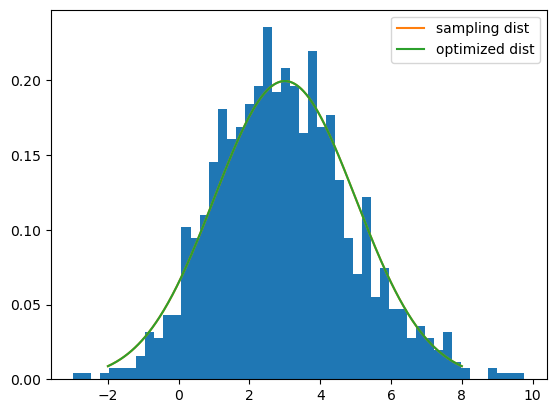

In [44]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(-2,8,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), np.sqrt(output_dist.gm.sigma[0][0,0].item())).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 5

``` 
if gm([1.], [_mean], [1.]) < 0 {
    a = gm([1.], [-5.], [1.]);
} else {
    a = gm([1.], [5.], [1.]);
} end if;
```

sample from the program with _mean = 0

In [18]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [19]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim5.soga')
cfg = produce_cfg(compiledFile)

In [20]:
pars = {'mean':0.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [21]:
output_dist = start_SOGA(cfg, params_dict)

In [22]:
output_dist

Dist<['a'],pi: [tensor(0.3085, grad_fn=<UnbindBackward0>), tensor(0.6915, grad_fn=<UnbindBackward0>)]  mu: [tensor([-5.], grad_fn=<CopySlices>), tensor([5.], grad_fn=<CopySlices>)] sigma: [tensor([[1.]], grad_fn=<CopySlices>), tensor([[1.]], grad_fn=<CopySlices>)]>

In [23]:
sampling_pi = torch.tensor(0.5)
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)

samples = torch.zeros((500,1))
latent = distributions.Bernoulli(sampling_pi).sample(samples.shape)
for i, r in enumerate(latent):
    if r:
        samples[i] = distributions.Normal(torch.tensor(-5.), torch.tensor(1.)).sample((1,))
    else:
        samples[i] = distributions.Normal(torch.tensor(5.), torch.tensor(1.)).sample((1,))

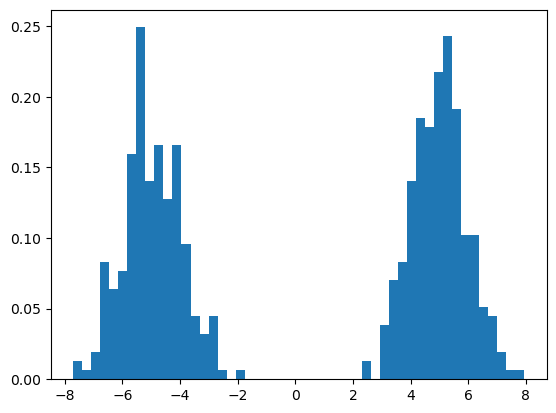

In [24]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

In [25]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    return -torch.sum(likelihood)

In [26]:
import torch

#pars = {'mean':2.}
#
## creates torch parameters for each params declared in the dictionary
#params_dict = {}
#for key, value in pars.items():
#    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(300):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 30 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 0.5099999904632568 loss: -73.22016143798828
mean: 0.8048593401908875 loss: -74.20230865478516
mean: 1.0738872289657593 loss: -74.92233276367188
mean: 1.305478572845459 loss: -75.39878845214844
mean: 1.50009286403656 loss: -75.70283508300781
mean: 1.6630675792694092 loss: -75.8977279663086
mean: 1.8005445003509521 loss: -76.0257797241211
mean: 1.9178835153579712 loss: -76.11260986328125
mean: 2.019322633743286 loss: -76.17343139648438
mean: 2.108097553253174 loss: -76.2173080444336


In [27]:
sampling_dist = Dist(['x'], GaussianMix([torch.tensor(0.5), torch.tensor(0.5)], [torch.tensor([-5.]), torch.tensor([5.])], [torch.tensor([[1.]]), torch.tensor([[1.]])]))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples, idx=0))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples, idx=0))

Likelihood with respect to the sampling distribution:  tensor(-71.2476)
Likelihood in the optimized distribution:  tensor(-76.2498, grad_fn=<NegBackward0>)


In [28]:
output_dist

Dist<['a'],pi: [tensor(0.0145, grad_fn=<UnbindBackward0>), tensor(0.9855, grad_fn=<UnbindBackward0>)]  mu: [tensor([-5.], grad_fn=<CopySlices>), tensor([5.], grad_fn=<CopySlices>)] sigma: [tensor([[1.]], grad_fn=<CopySlices>), tensor([[1.]], grad_fn=<CopySlices>)]>

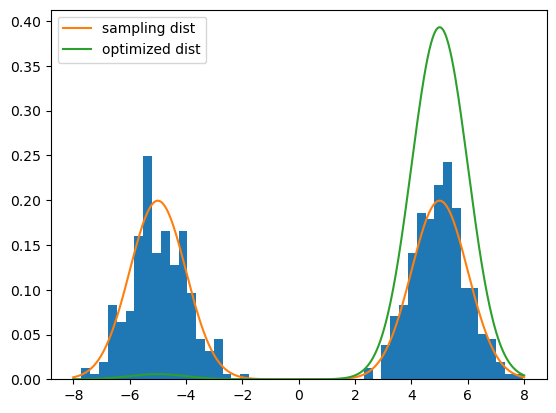

In [29]:
import matplotlib.pyplot as plt
from scipy.stats import norm


npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(-8,8,500)
y_sampling = sampling_dist.gm.marg_pdf(x, 0)
y_optim = output_dist.gm.marg_pdf(x, 0).detach()

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 6

``` 
if gm([1.], [0.], [1.]) < _coeff {
    a = gm([1.], [-5.], [1.]);
} else {
    a = gm([1.], [5.], [1.]);
} end if;
```

sample from the program with _coeff = 0

In [31]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [32]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim6.soga')
cfg = produce_cfg(compiledFile)

In [33]:
pars = {'coeff':0.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [34]:
output_dist = start_SOGA(cfg, params_dict)

In [35]:
output_dist

Dist<['a'],pi: [tensor(0.6915, grad_fn=<UnbindBackward0>), tensor(0.3085, grad_fn=<UnbindBackward0>)]  mu: [tensor([-5.], grad_fn=<CopySlices>), tensor([5.], grad_fn=<CopySlices>)] sigma: [tensor([[1.]], grad_fn=<CopySlices>), tensor([[1.]], grad_fn=<CopySlices>)]>

In [36]:
sampling_pi = torch.tensor(0.5)
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)

samples = torch.zeros((500,1))
latent = distributions.Bernoulli(sampling_pi).sample(samples.shape)
for i, r in enumerate(latent):
    if r:
        samples[i] = distributions.Normal(torch.tensor(-5.), torch.tensor(1.)).sample((1,))
    else:
        samples[i] = distributions.Normal(torch.tensor(5.), torch.tensor(1.)).sample((1,))

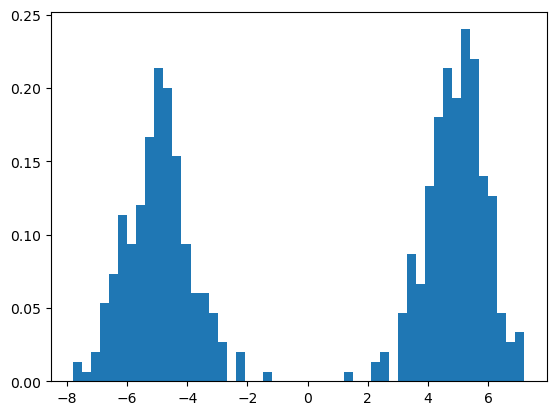

In [37]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

In [38]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    return -torch.sum(likelihood)

In [39]:
import torch

#pars = {'mean':2.}
#
## creates torch parameters for each params declared in the dictionary
#params_dict = {}
#for key, value in pars.items():
#    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(300):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 30 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


coeff: 0.49000000953674316 loss: -68.52520751953125
coeff: 0.18695411086082458 loss: -70.04568481445312
coeff: -0.12223006039857864 loss: -71.69259643554688
coeff: -0.4245647192001343 loss: -73.25308990478516
coeff: -0.7040160298347473 loss: -74.53717041015625
coeff: -0.9505761861801147 loss: -75.48469543457031
coeff: -1.1619476079940796 loss: -76.14097595214844
coeff: -1.341105580329895 loss: -76.58536529541016
coeff: -1.493106484413147 loss: -76.8875732421875
coeff: -1.623065710067749 loss: -77.096923828125


In [40]:
sampling_dist = Dist(['x'], GaussianMix([torch.tensor(0.5), torch.tensor(0.5)], [torch.tensor([-5.]), torch.tensor([5.])], [torch.tensor([[1.]]), torch.tensor([[1.]])]))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples, idx=0))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples, idx=0))

Likelihood with respect to the sampling distribution:  tensor(-71.0946)
Likelihood in the optimized distribution:  tensor(-77.2455, grad_fn=<NegBackward0>)


In [41]:
output_dist

Dist<['a'],pi: [tensor(0.0416, grad_fn=<UnbindBackward0>), tensor(0.9584, grad_fn=<UnbindBackward0>)]  mu: [tensor([-5.], grad_fn=<CopySlices>), tensor([5.], grad_fn=<CopySlices>)] sigma: [tensor([[1.]], grad_fn=<CopySlices>), tensor([[1.]], grad_fn=<CopySlices>)]>

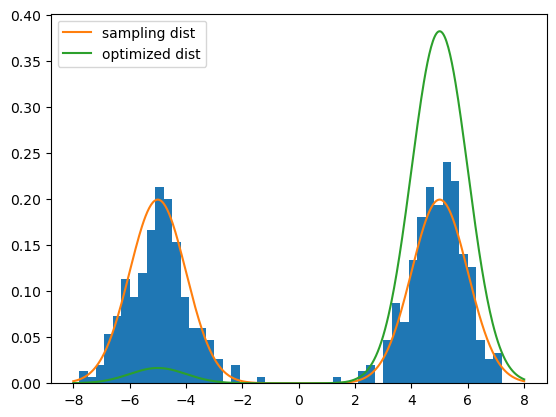

In [42]:
import matplotlib.pyplot as plt
from scipy.stats import norm


npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(-8,8,500)
y_sampling = sampling_dist.gm.marg_pdf(x, 0)
y_optim = output_dist.gm.marg_pdf(x, 0).detach()

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()